# Kwame's Zillow Zestimates Error Control

Table of contents with header links goes here.

## explore.ipynb

### When this section of the pipeline is done being coded, I will transfer internal code to ```explore.py``` and external code and output to the final notebook.

**I may make this the final notebook with a rename and cleanup.**

### Set up the environment

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import necessary packages/modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt

from wrangle import get_zillow_data, prepare_zillow
from preprocessing import zillow_main_split, zillow_Xy_split, impute_nulls, zillow_scale

# default viz size settings
plt.rc('figure', figsize=(10, 8))
plt.rc('font', size=15)

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

### Acquire the data

In [2]:
df = get_zillow_data()
df.shape

(77580, 69)

### Tidy the data

In [3]:
df = prepare_zillow(df)
df.head()

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,logerror,bathbedcnt
parcelid,,,,,,,,,
14297519,3.50,"3,100.00","33,634,931.00","-117,869,207.00",1,"1,998.00","1,023,282.00",0.03,7.50
17052889,1.00,"1,465.00","34,449,266.00","-119,281,531.00",2,"1,967.00","464,000.00",0.06,3.00
14186244,2.00,"1,243.00","33,886,168.00","-117,823,170.00",1,"1,962.00","564,778.00",0.01,5.00
12177905,3.00,"2,376.00","34,245,180.00","-118,240,722.00",0,"1,970.00","145,143.00",-0.10,7.00
12095076,3.00,"2,962.00","34,145,202.00","-118,179,824.00",0,"1,950.00","773,303.00",-0.00,7.00


### Summarize the clean data

In [4]:
df.shape

(52412, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52412 entries, 14297519 to 13083743
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bathcnt     52412 non-null  float64
 1   sqft        52330 non-null  float64
 2   latitude    52412 non-null  float64
 3   longitude   52412 non-null  float64
 4   county      52412 non-null  int64  
 5   yearbuilt   52296 non-null  float64
 6   value       52411 non-null  float64
 7   logerror    52412 non-null  float64
 8   bathbedcnt  52412 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 4.0 MB


In [6]:
df.isnull().sum()

bathcnt         0
sqft           82
latitude        0
longitude       0
county          0
yearbuilt     116
value           1
logerror        0
bathbedcnt      0
dtype: int64

The remaining nulls have to be imputed after the data split so that we aren't cheating with our data sets.

### Split the data into train, validate, test.

In [7]:
# main split
train, validate, test = zillow_main_split(df)

In [8]:
print(f'Shape of train data: {train.shape}')
print(f'Shape of validate data: {validate.shape}')
print(f'Shape of test data: {test.shape}')

Shape of train data: (29350, 9)
Shape of validate data: (12579, 9)
Shape of test data: (10483, 9)


### Impute the remaining nulls with medians.

In [9]:
train = impute_nulls(train)
train.isnull().sum()

bathcnt       0
sqft          0
latitude      0
longitude     0
county        0
yearbuilt     0
value         0
logerror      0
bathbedcnt    0
dtype: int64

In [10]:
validate = impute_nulls(validate)
validate.isnull().sum()

bathcnt       0
sqft          0
latitude      0
longitude     0
county        0
yearbuilt     0
value         0
logerror      0
bathbedcnt    0
dtype: int64

In [11]:
test = impute_nulls(test)
test.isnull().sum()

bathcnt       0
sqft          0
latitude      0
longitude     0
county        0
yearbuilt     0
value         0
logerror      0
bathbedcnt    0
dtype: int64

### Split the data into X and y train, X and y validate, X and y test.

In [12]:
X_train, X_validate, X_test, y_train, y_validate, y_test = zillow_Xy_split(train, validate, test)

In [13]:
# checking to make sure data was split correctly
print(f'Shape of X train data: {X_train.shape}')
print(f'Shape of X validate data: {X_validate.shape}')
print(f'Shape of X test data: {X_test.shape}')
print('\n')
print(f'Shape of y train data: {y_train.shape}')
print(f'Shape of y validate data: {y_validate.shape}')
print(f'Shape of y test data: {y_test.shape}')

Shape of X train data: (29350, 8)
Shape of X validate data: (12579, 8)
Shape of X test data: (10483, 8)


Shape of y train data: (29350,)
Shape of y validate data: (12579,)
Shape of y test data: (10483,)


### Scale the data

In [18]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = zillow_scale(X_train, X_validate, X_test)
X_train_scaled.head()

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt
parcelid,,,,,,,,
10750905,0.31,0.13,0.53,0.36,0.00,0.84,0.03,0.38
13051572,0.23,0.11,0.53,0.91,0.00,0.69,0.01,0.33
11419247,0.08,0.03,0.39,0.58,0.00,0.50,0.01,0.14
14025918,0.15,0.05,0.23,0.82,0.50,0.62,0.03,0.24
11842800,0.23,0.06,0.49,0.70,0.00,0.35,0.02,0.38


### Explore the data and create visualizations

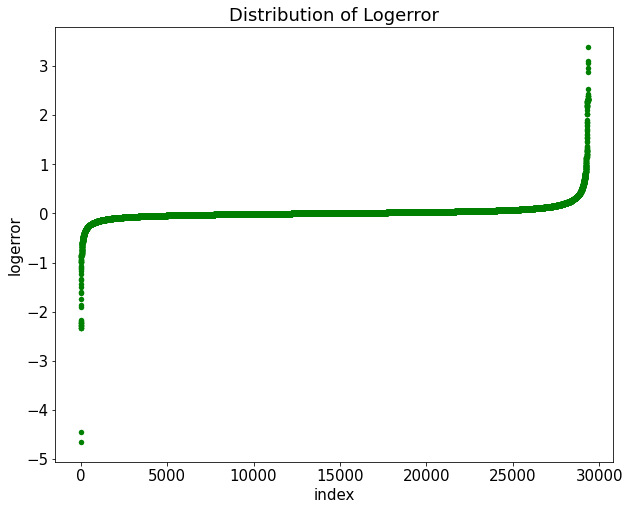

In [21]:
# visualize logerror
sns.scatterplot(range(train.shape[0]), np.sort(train.logerror.values), color='green', linewidth=0 , s=30)
plt.xlabel('index')
plt.ylabel('logerror')
plt.title('Distribution of Logerror')
plt.show()

**There are outliers present, especially on the side of negative logerror. I will handle these on the next iteration of this section.**

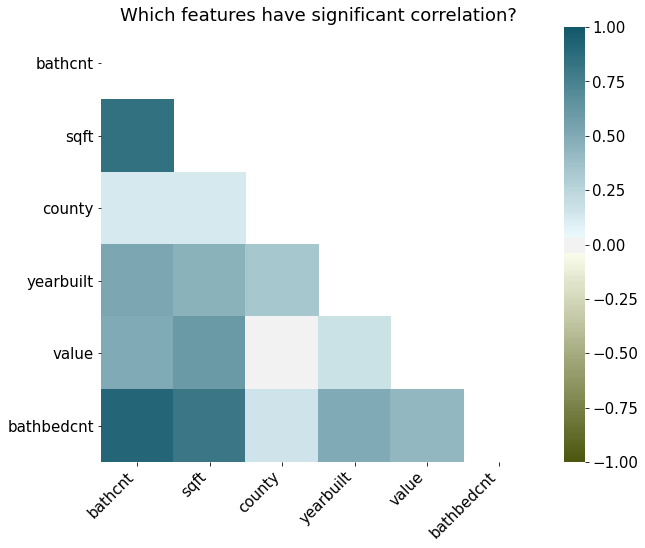

In [19]:
# heatmap time!
heatmap_data = X_train_scaled.drop(columns=['latitude', 'longitude'])
corr = heatmap_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, center=0, vmin=-1, vmax=1, cmap=sns.diverging_palette(95, 220, n=250, s=93, l=35), square=True) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.title('Which features have significant correlation?')
ax

In [ ]:
# heatmap time!
heatmap_data = X_train_scaled.drop(columns=['latitude', 'longitude'])
corr = heatmap_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, center=0, vmin=-1, vmax=1, cmap=sns.diverging_palette(95, 220, n=250, s=93, l=35), square=True) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.title('Which features have more log error?')
ax

### One statistical test